## Using Cnn to detect the Cancer chances 

#### Importing The libraries

In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense , Conv2D , MaxPooling2D , Dropout , Flatten 
from tensorflow.keras.applications import EfficientNetB0
import matplotlib.pyplot as plt
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam

In [2]:
tf.__version__

'2.19.0'

## Convolution Neural Network

In [3]:
base_dir = "IQ-OTH_NCCD"  ## Name of the File where all the Dataset are stored

#  Set Parameters
img_size = (299, 299)     ## Image Size Adjusted
batch_size = 16           ## Batch Size Adjusted

### Preprocessing the Training set

In [4]:
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,
    zoom_range=0.1,
    horizontal_flip=True
)

train_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True)

val_generator = datagen.flow_from_directory(
    directory=base_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=False)
 

Found 878 images belonging to 3 classes.
Found 219 images belonging to 3 classes.


## Data Preprocessing 

#### Convolution layer and Max_pooling

In [5]:
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Sequential

model = Sequential([
    Input(shape=(299, 299,3)),

    # 1st Convolution Layer
    Conv2D(32, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2,2),

    # 2nd Convolution Layer
    Conv2D(64, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2)),

    # 3rd Convolution Layer
    Conv2D(128, (3,3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2,2))
])

#### Flatten

In [6]:
model.add(Flatten())

## Full Connection of layers

In [7]:
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))

### Output Layers

##### We use 'sigmoid' for manage the error... and We can also use  'Softmax'

In [8]:
model.add(Dense(units=3,activation='softmax'))

## Training The CNN

In [9]:
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

## Use Learning Rate Scheduling

### EarlyStopping + ReduceLROnPlateau
### Use both to prevent overfitting and improve training dynamics.

In [10]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [11]:
print(train_generator.class_indices)
print(np.bincount(train_generator.classes))

{'Benign': 0, 'Malignant': 1, 'Normal': 2}
[ 96 449 333]


# Training the CNN Model

### Training After EarlyStopping + ReduceLROnPlateau in CNN Model

In [13]:
history = model.fit(
    train_generator,
    epochs=20,
    validation_data=val_generator,
    callbacks=[lr_callback]
)

Epoch 1/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 64s 1s/step - accuracy: 0.6484 - loss: 17.1744 - val_accuracy: 0.5571 - val_loss: 43.7432 - learning_rate: 0.0010
Epoch 2/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.6798 - loss: 0.8074 - val_accuracy: 0.5114 - val_loss: 121.3878 - learning_rate: 0.0010
Epoch 3/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 67s 1s/step - accuracy: 0.6079 - loss: 0.8914 - val_accuracy: 0.5114 - val_loss: 167.7517 - learning_rate: 0.0010
Epoch 4/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 71s 1s/step - accuracy: 0.6822 - loss: 0.8349 - val_accuracy: 0.5114 - val_loss: 259.9599 - learning_rate: 0.0010
Epoch 5/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 76s 1s/step - accuracy: 0.7500 - loss: 0.8868 - val_accuracy: 0.5114 - val_loss: 196.7046 - learning_rate: 2.0000e-04
Epoch 6/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 69s 1s/step - accuracy: 0.7436 - loss: 0.6322 - val_accuracy: 0.5114 - val_loss: 160.7589 - learning_rate: 2.0000e-04
Epoch 7/20
55/55 ━━━━━━━━━━━━━━━━━━━━ 68s 1s/step - accuracy: 0.7891 - loss: 0.6

## Making prediction on Training set 

In [14]:

val_generator.reset()
predictions = model.predict(val_generator)
y_pred = np.argmax(predictions, axis=1)
y_true = val_generator.classes

14/14 ━━━━━━━━━━━━━━━━━━━━ 4s 281ms/step


In [15]:
from sklearn.metrics import confusion_matrix , accuracy_score

cm = confusion_matrix(y_true , y_pred)
print(cm)

accuracy_score(y_true , y_pred)

[[  0   0  24]
 [  0 105   7]
 [  0  11  72]]


0.8082191780821918

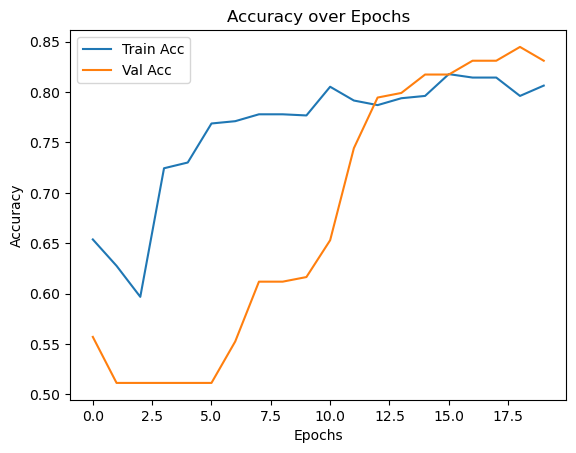

In [16]:
plt.plot(history.history['accuracy'], label="Train Acc")
plt.plot(history.history['val_accuracy'], label="Val Acc")
plt.title("Accuracy over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


## Making a Single Prediction 